#0 Import of used packages

In [2]:
# Import used packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(style="whitegrid", context="paper", font_scale=1.5, font = "Times New Roman")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#01 Import of dataset, data exploration and preparation

In [4]:
# Set filepath and import raw data
file_path = "/content/drive/MyDrive/Bachelorarbeit/Bicycle Crossing (count data - Poisson Regression)/Dataset/bicycle_crossing.xlsx"
bicycle_crossing_raw = pd.read_excel(file_path)

print(bicycle_crossing_raw.shape)

(214, 9)


## 1.1 Data Preparation

In [5]:
# Create copy of raw data
bicycle_crossing = bicycle_crossing_raw.copy()
bicycle_crossing.head(5)

,Date,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,2017-04-01,46.0,37.0,0,606,1446,1915,1430,5397
1,2017-04-02,62.1,41.0,0,2021,3943,4207,2862,13033
2,2017-04-03,63.0,50.0,0.03,2470,4988,5178,3689,16325
3,2017-04-04,51.1,46.0,1.18,723,1913,2279,1666,6581
4,2017-04-05,63.0,46.0,0,2807,5276,5711,4197,17991


In [6]:
# Check for missing data
bicycle_crossing.isna().sum()

Date                   0
High Temp (°F)         0
Low Temp (°F)          0
Precipitation          0
Brooklyn Bridge        0
Manhattan Bridge       0
Williamsburg Bridge    0
Queensboro Bridge      0
Total                  0
dtype: int64

In [7]:
# Check for duplicate rows
duplicate_rows_df = bicycle_crossing[bicycle_crossing.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)

number of duplicate rows: (0, 9)


In [8]:
# Format column "Date" properly
bicycle_crossing["Date"] = pd.to_datetime(bicycle_crossing["Date"])
type(bicycle_crossing["Date"])

pandas.core.series.Series

In [9]:
# Extract "Day_of_Week" as additional feature from the day_column containing the string for the day of the week of the corresponding date
bicycle_crossing['Day_of_Week'] = bicycle_crossing["Date"].dt.day_name()

In [10]:
# Add addtional feature "AVG Temp (F)" representing the average temperature based on the highest and lowest temperature for the day
bicycle_crossing["Avg Temp (°F)"] = (bicycle_crossing["Low Temp (°F)"] + bicycle_crossing["High Temp (°F)"])/2

In [11]:
# Drop columns that are not used for prediction
columns_to_drop = ['Brooklyn Bridge', 'Williamsburg Bridge', 'Queensboro Bridge', 'Total']
bicycle_crossing = bicycle_crossing.drop(columns=columns_to_drop, errors='ignore')

# Display current dataframe
bicycle_crossing.head()

,Date,High Temp (°F),Low Temp (°F),Precipitation,Manhattan Bridge,Day_of_Week,Avg Temp (°F)
0,2017-04-01,46.0,37.0,0,1446,Saturday,41.50
1,2017-04-02,62.1,41.0,0,3943,Sunday,51.55
2,2017-04-03,63.0,50.0,0.03,4988,Monday,56.50
3,2017-04-04,51.1,46.0,1.18,1913,Tuesday,48.55
4,2017-04-05,63.0,46.0,0,5276,Wednesday,54.50


In [12]:
# Check for values in "Precipitation"
print(set(bicycle_crossing["Precipitation"]))

{0, 1.18, 0.73, 0.29, 0.91, 0.34, 0.06, 3.02, 1.31, 0.59, 1.39, 0.42, 3.03, 0.25, 0.76, 0.26, 0.18, 0.35, 'T', 0.11, 1.35, 0.04, 0.53, 0.45, 1.78, 0.2, 0.03, 0.17, 0.1, 0.09, 0.23, 0.15, 1.29, 0.22, 0.13, 0.88, 0.3, 0.02, 0.08, 0.57, 0.01, 0.07, 0.74, 0.58}


In [13]:
# "T" represents "Trace" meaning very low signs of precipitation. Therefore samples with "T" as "Precipitation" will be replaced with 0.001
bicycle_crossing['Precipitation'].replace('T', 0.001, inplace=True)

# Display current dataframe
bicycle_crossing.head()

,Date,High Temp (°F),Low Temp (°F),Precipitation,Manhattan Bridge,Day_of_Week,Avg Temp (°F)
0,2017-04-01,46.0,37.0,0.00,1446,Saturday,41.50
1,2017-04-02,62.1,41.0,0.00,3943,Sunday,51.55
2,2017-04-03,63.0,50.0,0.03,4988,Monday,56.50
3,2017-04-04,51.1,46.0,1.18,1913,Tuesday,48.55
4,2017-04-05,63.0,46.0,0.00,5276,Wednesday,54.50


In [14]:
# Perform One-Hot-Encoding for "Day_of_Week"-Variable
weekday_dummies = pd.get_dummies(bicycle_crossing['Day_of_Week'], prefix='Day')
bicycle_crossing = bicycle_crossing.join(weekday_dummies).drop("Day_of_Week", axis = 1)

# Display current dataframe
bicycle_crossing.head()

,Date,High Temp (°F),Low Temp (°F),Precipitation,Manhattan Bridge,Avg Temp (°F),Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,2017-04-01,46.0,37.0,0.00,1446,41.50,0,0,1,0,0,0,0
1,2017-04-02,62.1,41.0,0.00,3943,51.55,0,0,0,1,0,0,0
2,2017-04-03,63.0,50.0,0.03,4988,56.50,0,1,0,0,0,0,0
3,2017-04-04,51.1,46.0,1.18,1913,48.55,0,0,0,0,0,1,0
4,2017-04-05,63.0,46.0,0.00,5276,54.50,0,0,0,0,0,0,1


In [15]:
# Convert columns to float
columns_to_convert = ['High Temp (°F)','Low Temp (°F)','Precipitation','Manhattan Bridge','Day_Friday','Day_Monday',
                      'Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']
bicycle_crossing[columns_to_convert] = bicycle_crossing[columns_to_convert].astype(float)
bicycle_crossing_final = bicycle_crossing

# Check variavle descriptions for anomalies
bicycle_crossing_final.describe()

,High Temp (°F),Low Temp (°F),Precipitation,Manhattan Bridge,Avg Temp (°F),Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,74.201869,62.027103,0.131841,5345.485981,68.114486,0.140187,0.144860,0.144860,0.144860,0.140187,0.144860,0.140187
std,10.390443,9.305792,0.394194,1746.546523,9.571633,0.347995,0.352785,0.352785,0.352785,0.347995,0.352785,0.347995
min,46.000000,37.000000,0.000000,484.000000,41.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66.900000,55.225000,0.000000,4308.000000,60.962500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,75.900000,64.000000,0.000000,5607.500000,69.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,82.000000,70.000000,0.037500,6759.500000,75.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,93.900000,78.100000,3.030000,8239.000000,86.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.2 Data Exploration

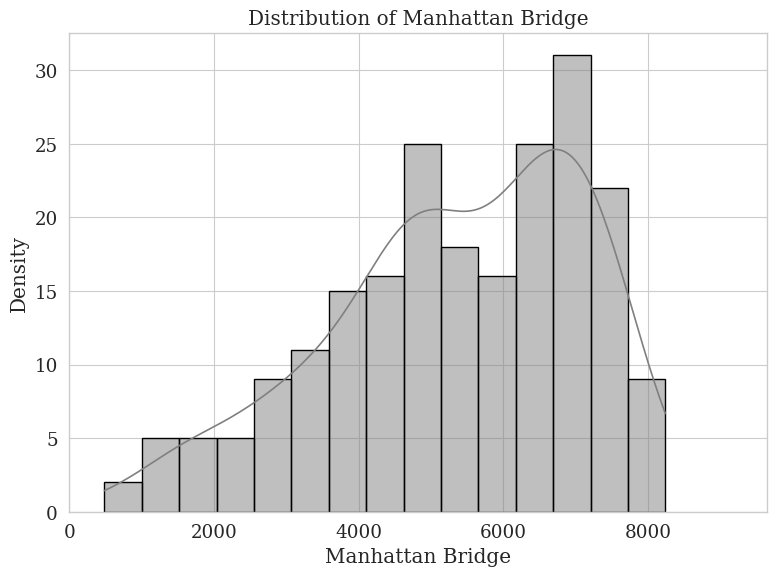

In [16]:
# Create figure and axis to control size and resolution
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# Create density plot and histogram
sns.histplot(data=bicycle_crossing_final, x='Manhattan Bridge', kde=True, bins = 15, color='gray', edgecolor='black', linewidth=1, ax=ax)

# Adding grid lines
ax.grid(True)

# Customizing
ax.set_title('Distribution of Manhattan Bridge')
ax.set_xlabel('Manhattan Bridge')
ax.set_ylabel('Density')

# Adjust x-axis based on value range of "Manhattan Bridge"
max_cost = bicycle_crossing_final['Manhattan Bridge'].quantile(0.95)  #Plotting the 95th percentile for better visibility
ax.set_xlim(0, max_cost+2000)

plt.tight_layout()

plt.show()

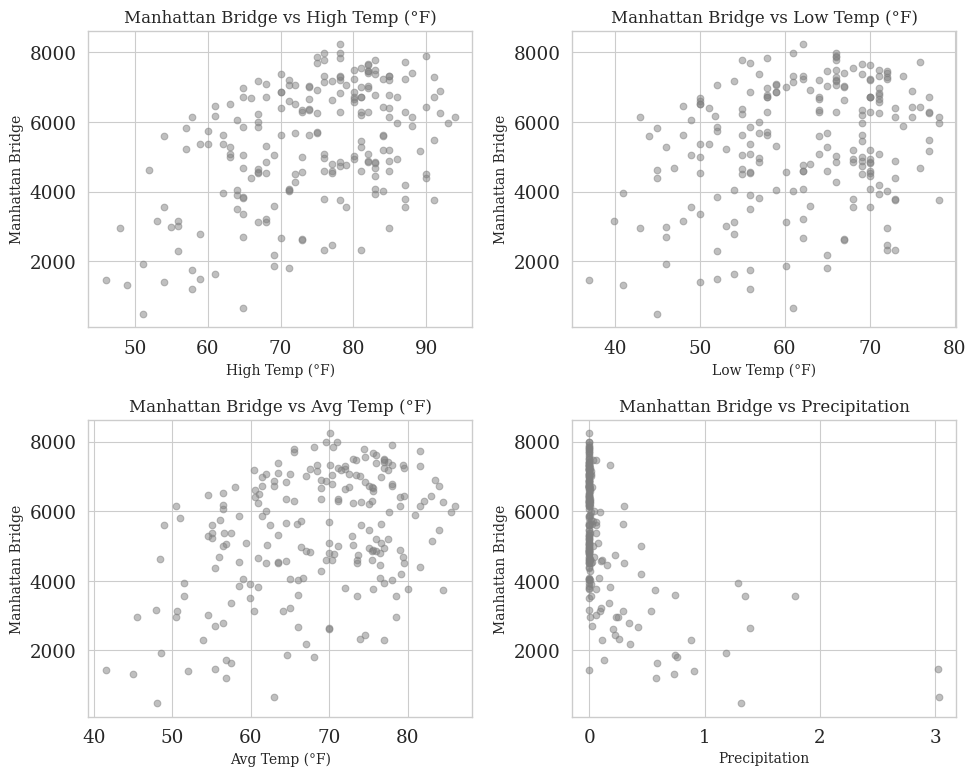

In [17]:
# Target and predictors as specified
target = 'Manhattan Bridge'
predictors = ['High Temp (°F)', 'Low Temp (°F)', 'Avg Temp (°F)', "Precipitation"]

# Create a grid of subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Adjusted to 2 rows and 2 columns
axs = axs.flatten()  # Flatten the array of axes for easy indexing

# Create a scatter plot for each predictor
for i, predictor in enumerate(predictors):
    axs[i].scatter(bicycle_crossing_final[predictor], bicycle_crossing_final[target], alpha=0.5, color='gray')
    axs[i].set_title(f'{target} vs {predictor}', fontsize = 12)
    axs[i].set_xlabel(predictor, fontsize = 10)
    axs[i].set_ylabel(target, fontsize = 10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

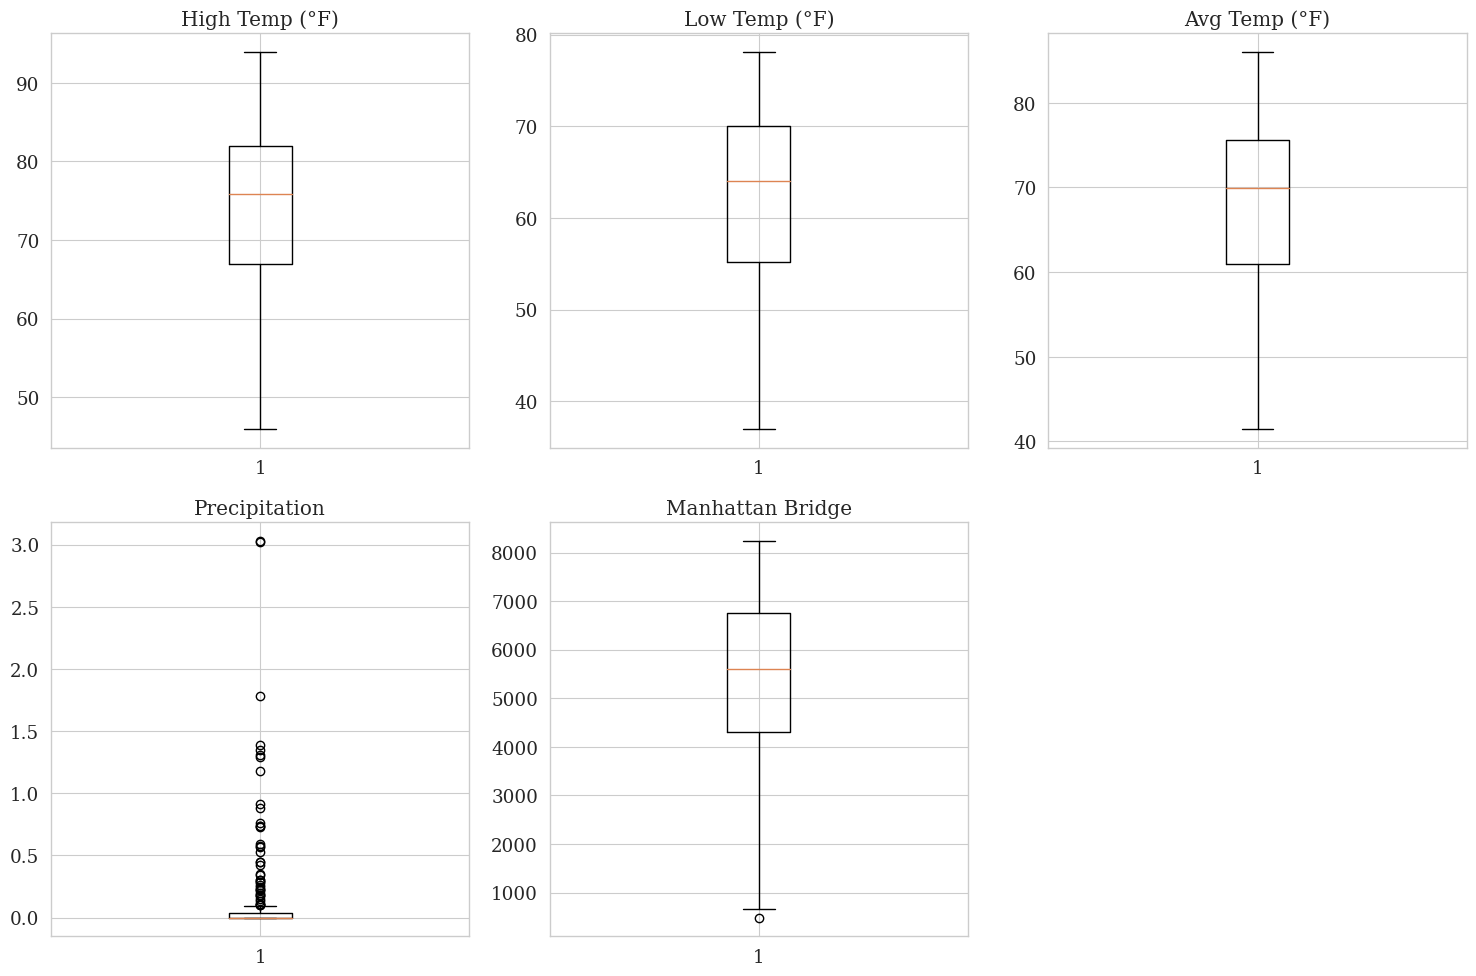

In [18]:
data_for_plot = bicycle_crossing_final[['High Temp (°F)', 'Low Temp (°F)', 'Avg Temp (°F)', 'Precipitation', 'Manhattan Bridge']]

# Determine the number of rows and columns for the subplots
num_variables = len(data_for_plot.columns)
ncols = 3  # Number of columns per row
nrows = (num_variables + ncols - 1) // ncols  # Calculates the required number of rows

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows)) # Adjust figure size as needed
axs = axs.flatten()  # Flatten the array of axes

# Plotting boxplots for each column
for i, column in enumerate(data_for_plot.columns):
    axs[i].boxplot(data_for_plot[column])
    axs[i].set_title(column)

# Hide any unused subplots
for i in range(num_variables, nrows * ncols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

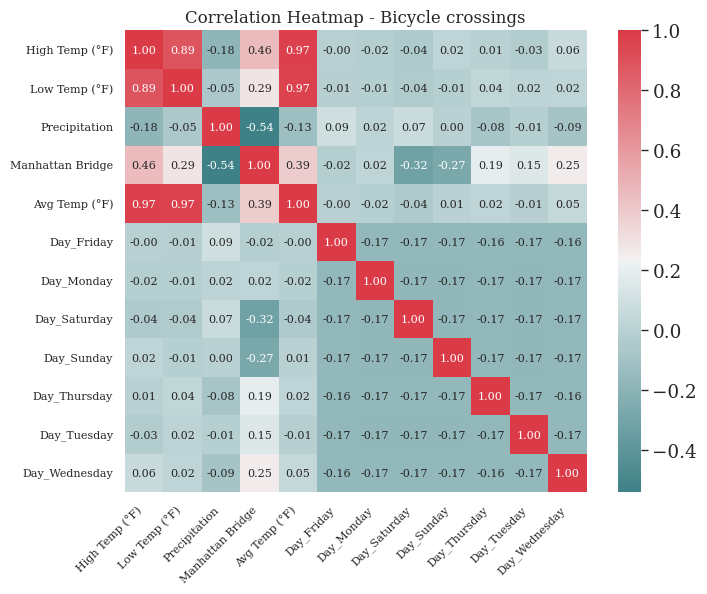

In [19]:
# Drop "Date" column from the dataframe as not needed for correlation heatmap
columns = bicycle_crossing_final.drop("Date", axis = 1).columns
correlation_df = bicycle_crossing_final[columns].corr()

# Initialize the matplotlib figure
fig, axs = plt.subplots(figsize=(8, 6))

# Generate heatmap using sns.heatmap-function
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap=sns.diverging_palette(200, 10, as_cmap=True),
            square=True, ax=axs, annot_kws={"size": 8})

# Adjust the plot for readability
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.yticks(rotation=0, fontsize = 8)
plt.title('Correlation Heatmap - Bicycle crossings', fontsize = 12)

# Show the plot
plt.show()

## 1.3 Create and visualize training and test-dataset

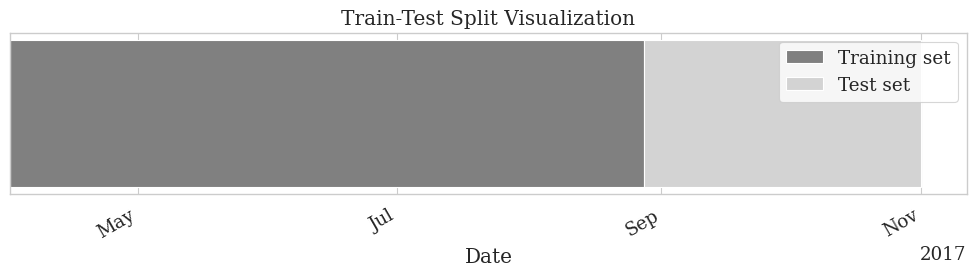

In [20]:
def plot_train_test_split(df, date_column_name, test_size=0.3):
    """
    :param df: DataFrame including features and target.
    :param date_column_name: str, name of the date column.
    :param test_size: float, represent the proportion of the dataset to include in the test split.

    """
    # Sort dataframe according to date column
    df.sort_values(date_column_name, inplace=True)

    # Perform the split
    train_size = int(len(df) * (1 - test_size))
    training_set, test_set = df.iloc[:train_size], df.iloc[train_size:]

    # Extract dates for plotting
    dates_train = training_set[date_column_name]
    dates_test = test_set[date_column_name]

    # Create a figure
    plt.figure(figsize=(10, 3))

    # Define the locator and formatter for the dates on the x-axis
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)

    # Plot training indices with dates
    plt.barh(y=1, width=len(dates_train), left=dates_train.min(), color='gray', height=0.5, label='Training set')
    # Plot testing indices with dates
    plt.barh(y=1, width=len(dates_test), left=dates_test.min(), color='lightgray', height=0.5, label='Test set')

    # Set the locator and formatter for the x-axis
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Formatting the x-axis with dates
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Rotate dates to prevent overlap
    plt.gcf().autofmt_xdate()

    # Adding labels and title
    plt.xlabel('Date')
    plt.yticks([])
    plt.title('Train-Test Split Visualization')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    return training_set, test_set

# Call the function to visualize the split
training_set, test_set = plot_train_test_split(bicycle_crossing_final, "Date", test_size=0.3)

# 02 Modelling, Cross Validation and Prediction - GLM



In [21]:
# Reset indeces of training and test set to ensure correct TimeSeriesCrossValidation
training_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Create target and feature vector for training set
X_train = training_set.drop(["Date", "Manhattan Bridge"], axis=1)
y_train = training_set['Manhattan Bridge']

# Create target and feature vector for test set
X_test = test_set.drop(["Date", "Manhattan Bridge"], axis=1)
y_test = test_set['Manhattan Bridge']

In [22]:
# Add constant to X_train. This will serve as the intercept in the regression model
X_train = sm.add_constant(X_train)

# Create GLM with Poisson distribution and canonical link function
glm_poisson = sm.GLM(y_train, X_train, family=sm.families.Poisson())

# Fit the model and print model summary
glm__poisson_results = glm_poisson.fit()
print(glm__poisson_results.summary2())

               Results: Generalized linear model
Model:               GLM              AIC:            32264.6870
Link Function:       Log              BIC:            30011.6890
Dependent Variable:  Manhattan Bridge Log-Likelihood: -16122.   
Date:                2024-02-11 22:08 LL-Null:        -51203.   
No. Observations:    149              Deviance:       30707.    
Df Model:            9                Pearson chi2:   2.93e+04  
Df Residuals:        139              Scale:          1.0000    
Method:              IRLS                                       
----------------------------------------------------------------
                Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
const           6.7099   0.0073  913.8099 0.0000  6.6956  6.7243
High Temp (°F)  0.0204   0.0003   80.8336 0.0000  0.0200  0.0209
Low Temp (°F)  -0.0133   0.0003  -49.4090 0.0000 -0.0139 -0.0128
Precipitation  -0.6132   0.0050 -123.0325

In [23]:
# Add constant to X_train. This will serve as the intercept in the feature vector
X_test = sm.add_constant(X_test)

# Make predictions
y_pred_poisson = glm__poisson_results.predict(X_test)

# Calculate performance metrics (MSE, RMSE, MAE)
mse = mean_squared_error(y_test, y_pred_poisson)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_poisson)

# Print the results
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 876268.190
Mean RMSE: 936.092
Mean MAE: 756.054


In [24]:
# Perform auxillary OLS regression
# Create a copy of current training set
df_aux_olsr = training_set.copy()

#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set
df_aux_olsr['BB_LAMBDA'] = glm__poisson_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
df_aux_olsr['AUX_OLS_DEP'] = df_aux_olsr.apply(lambda x: ((x['Manhattan Bridge'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, df_aux_olsr).fit()

#Print the regression params
print(aux_olsr_results.params[0])

0.02914153116473388


In [25]:
aux_olsr_results.tvalues

BB_LAMBDA    6.019913
dtype: float64

In [26]:
# Create Negative Binomial model with estimated parameter alpha
glm_negbin = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

#Fit the model and print summary
glm_negbin_results = glm_negbin.fit()
print(glm_negbin_results.summary2())

               Results: Generalized linear model
Model:               GLM              AIC:            2600.8140
Link Function:       Log              BIC:            -390.9143
Dependent Variable:  Manhattan Bridge Log-Likelihood: -1290.4  
Date:                2024-02-11 22:08 LL-Null:        -1553.4  
No. Observations:    149              Deviance:       304.63   
Df Model:            9                Pearson chi2:   255.     
Df Residuals:        139              Scale:          1.0000   
Method:              IRLS                                      
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
const           6.4656   0.0851  76.0052 0.0000  6.2989  6.6323
High Temp (°F)  0.0259   0.0031   8.3367 0.0000  0.0198  0.0320
Low Temp (°F)  -0.0167   0.0033  -5.0059 0.0000 -0.0233 -0.0102
Precipitation  -0.4825   0.0386 -12.4914 0.0000 -0.5583

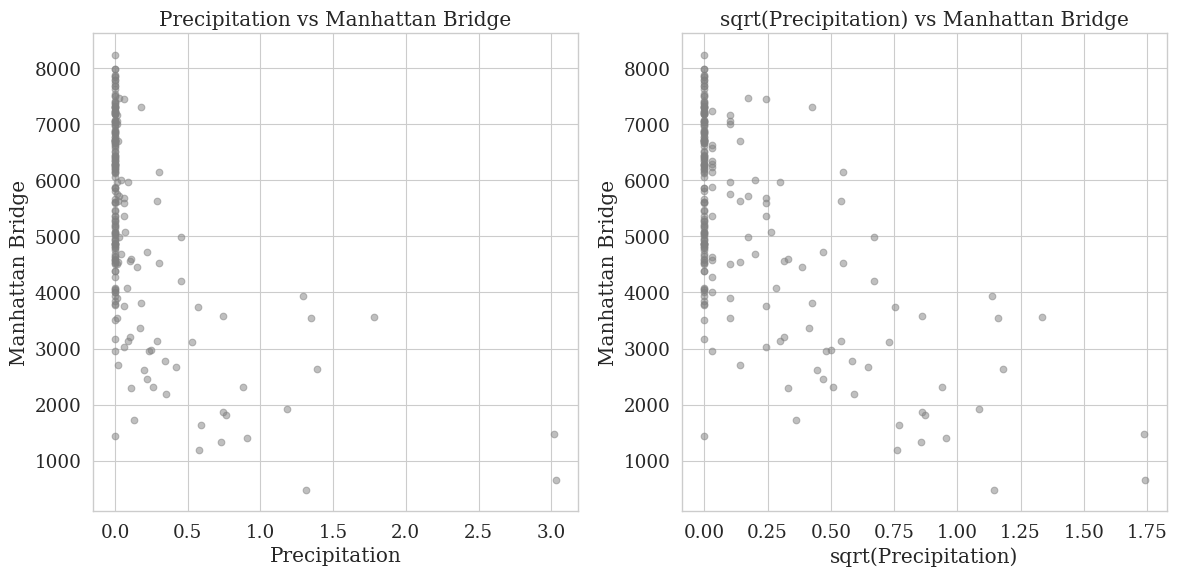

In [27]:
# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting Precipitation vs Manhattan Bridge using Scatterplot
axs[0].scatter(bicycle_crossing_final["Precipitation"], bicycle_crossing_final[target], alpha=0.5, color='gray')
axs[0].set_xlabel('Precipitation')
axs[0].set_ylabel('Manhattan Bridge')
axs[0].set_title('Precipitation vs Manhattan Bridge')

# Plotting sqrt(Precipitation) vs Manhattan Bridge using Scatterplot
axs[1].scatter(np.sqrt(bicycle_crossing_final["Precipitation"]), bicycle_crossing_final[target], alpha=0.5, color='gray')
axs[1].set_xlabel('sqrt(Precipitation)')
axs[1].set_ylabel('Manhattan Bridge')
axs[1].set_title('sqrt(Precipitation) vs Manhattan Bridge')

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

In [28]:
# The linear relationship of Precipitation seem to improve by taking the sqrt-function of it
X_train["Precipitation"] = np.sqrt(X_train["Precipitation"])
X_test["Precipitation"] = np.sqrt(X_test["Precipitation"])

In [29]:
# Create Negative Binomial model with estimated parameter alpha
glm_negbin = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

#Fit the model and print summary
glm_negbin_results = glm_negbin.fit()
print(glm_negbin_results.summary2())

               Results: Generalized linear model
Model:               GLM              AIC:            2546.5645
Link Function:       Log              BIC:            -445.1639
Dependent Variable:  Manhattan Bridge Log-Likelihood: -1263.3  
Date:                2024-02-11 22:08 LL-Null:        -1553.4  
No. Observations:    149              Deviance:       250.38   
Df Model:            9                Pearson chi2:   219.     
Df Residuals:        139              Scale:          1.0000   
Method:              IRLS                                      
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
const           6.5533   0.0865  75.8024 0.0000  6.3838  6.7227
High Temp (°F)  0.0206   0.0032   6.4697 0.0000  0.0144  0.0269
Low Temp (°F)  -0.0113   0.0034  -3.3142 0.0009 -0.0180 -0.0046
Precipitation  -0.7005   0.0467 -15.0014 0.0000 -0.7920

In [30]:
# Calculate influence measures
influence_glm = glm_negbin_results.get_influence()

# Obtain summary measures of influence
summaries = influence_glm.summary_frame()

# Cook's distance is one of the summary measures provided
cooks_d_glm = summaries['cooks_d']

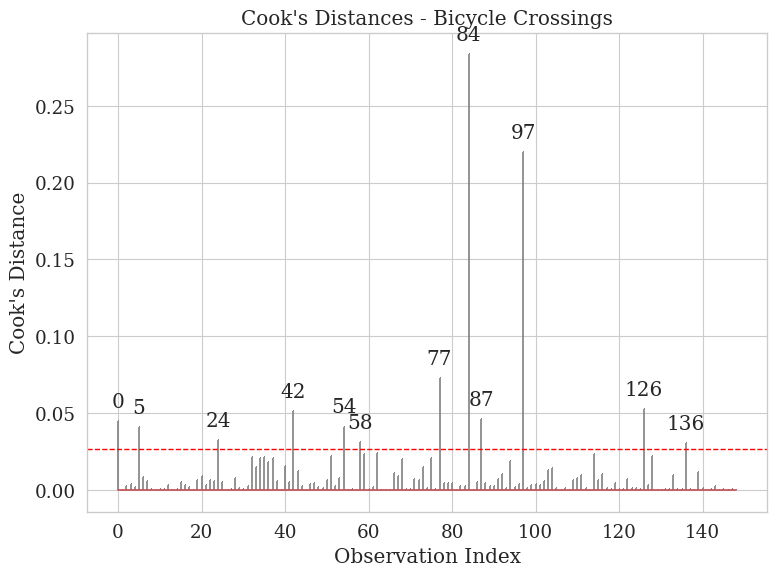

In [31]:
# Take a threshold of 4/N
threshold = 4/len(X_train)

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.stem(np.arange(len(cooks_d_glm)), cooks_d_glm, markerfmt=',', use_line_collection=True, linefmt='gray')

# Setting the title and labels
ax.set_title('Cook\'s Distances - Bicycle Crossings')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Cook\'s Distance')

# Adding a horizontal line for the Cook's distance threshold
ax.axhline(y=threshold, ls='--', c='red', linewidth=1)

# Adding grid lines
ax.grid(True)

# Annotate the points above the threshold
for i, cd in enumerate(cooks_d_glm):
    if cd > threshold:
        ax.annotate(f"{i}", (i, cd), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [32]:
# Identify all points where Cook's distance is above the threshold
influential_points = cooks_d_glm > threshold

# Create an array of indices for influential points
influential_indices = np.where(influential_points)[0]

size_before = len(X_train)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Now try to drop the rows by index
X_train = X_train.drop(index=influential_indices)
y_train = y_train.drop(index=influential_indices)

print("Removed Outliers:", size_before-len(X_train))

Removed Outliers: 12


In [33]:
# Create Negative Binomial model with estimated parameter alpha and cleaned target and feature vectors
glm_negbin = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))

#Fit the model and print summary
glm_negbin_results = glm_negbin.fit()
print(glm_negbin_results.summary2())

               Results: Generalized linear model
Model:               GLM              AIC:            2242.8456
Link Function:       Log              BIC:            -513.0528
Dependent Variable:  Manhattan Bridge Log-Likelihood: -1111.4  
Date:                2024-02-11 22:08 LL-Null:        -1306.3  
No. Observations:    137              Deviance:       111.78   
Df Model:            9                Pearson chi2:   103.     
Df Residuals:        127              Scale:          1.0000   
Method:              IRLS                                      
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
const           6.9134   0.0940  73.5679 0.0000  6.7292  7.0976
High Temp (°F)  0.0152   0.0033   4.5657 0.0000  0.0087  0.0217
Low Temp (°F)  -0.0093   0.0035  -2.6369 0.0084 -0.0163 -0.0024
Precipitation  -0.7718   0.0578 -13.3423 0.0000 -0.8852

In [34]:
# Initialize feature vector and target vector
X = X_train
y = y_train

# Create arrays for performance metrics per fold
mse_fold, rmse_fold, mae_fold = [], [], []

# Create TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):

    # Split the data into training and test sets for the current fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Add a constant to the model (if you're using statsmodels, it doesn't add a constant by default)
    X_train_fold = sm.add_constant(X_train_fold)
    X_test_fold = sm.add_constant(X_test_fold)

    # Define the GLM model with the Negative Binomial family and fit it to the training data
    glm_negbin = sm.GLM(y_train_fold, X_train_fold, family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0]))
    glm_results = glm_negbin.fit()

    # Now you can use glm_results to make predictions and evaluate the model
    y_pred = glm_results.predict(X_test_fold)

    # Evaluate the model performance using MSE, RMSE, MAE
    mse = mean_squared_error(y_test_fold, y_pred)
    mse_fold.append(mse)
    rmse = np.sqrt(mse)
    rmse_fold.append(rmse)
    mae = mean_absolute_error(y_test_fold, y_pred)
    mae_fold.append(mae)

#Print results
print("MSE per Fold:", mse_fold)
print("RMSE per Fold:", rmse_fold)
print("MAE per Fold:", mae_fold)

MSE per Fold: [751205.6793929343, 1212858.9282511903, 1072802.568694641, 931708.2093298301, 319684.27107239095]
RMSE per Fold: [866.7212235736092, 1101.298746140751, 1035.761830101226, 965.2503350581289, 565.4062884973874]
MAE per Fold: [748.8182338400347, 869.4307172127941, 813.0050884113775, 765.7412609249368, 445.27827147745484]


In [35]:
# Print the results
print(f"Mean MSE: {np.mean(mse_fold):.3f}")
print(f"Mean RMSE: {np.mean(rmse_fold):.3f}")
print(f"Mean MAE: {np.mean(mae_fold):.3f}")

Mean MSE: 857651.931
Mean RMSE: 906.888
Mean MAE: 728.455


In [36]:
# Refit final model with complete training data
glm_negbin_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha = aux_olsr_results.params[0])).fit()

In [37]:
# Make predictions
y_pred_negbin = glm_negbin_results.predict(X_test)

#Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_negbin)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_negbin)

# Print the results
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 561739.353
Mean RMSE: 749.493
Mean MAE: 597.703


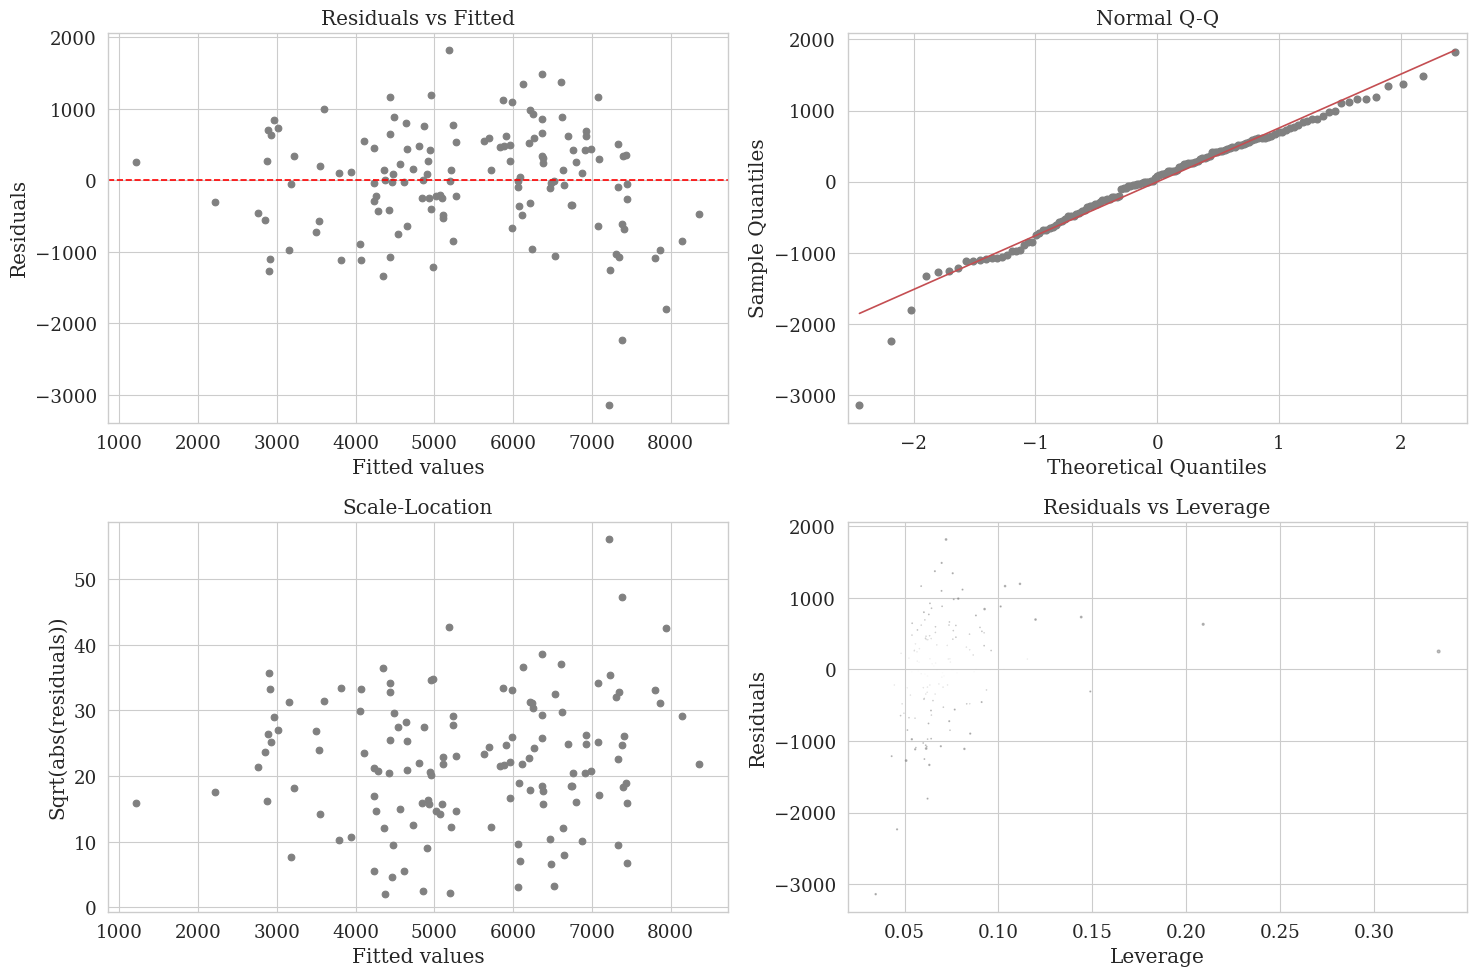

In [38]:
# Create diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Fitted
axs[0, 0].scatter(glm_negbin_results.fittedvalues, glm_negbin_results.resid_response, color = "gray")
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

# Normal Q-Q
sm.qqplot(glm_negbin_results.resid_response, line='s', ax=axs[0, 1], markeredgecolor='gray', markerfacecolor='gray')
axs[0, 1].set_title('Normal Q-Q')

# Scale-Location
axs[1, 0].scatter(glm_negbin_results.fittedvalues, np.sqrt(np.abs(glm_negbin_results.resid_response)), color = "gray")
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('Sqrt(abs(residuals))')

# Residuals vs Leverage
# We will use the cooks distance as a measure for the leverage plot
influence = glm_negbin_results.get_influence()
cooks = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
axs[1, 1].scatter(leverage, glm_negbin_results.resid_response, s=50 * cooks, alpha=0.5, color = "gray")
axs[1, 1].set_title('Residuals vs Leverage')
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# 03 Modelling, Cross Validation and Prediction - Random Forest


In [39]:
# Recreate identical training set, as it was modified for generalized linear model

# Sort final dataframe by date-column to avoid data leakage
bicycle_crossing_final.sort_values("Date", inplace=True)

# Perform the split
train_size = int(len(bicycle_crossing_final) * (1 - 0.3))
training_set, test_set = bicycle_crossing_final.iloc[:train_size], bicycle_crossing_final.iloc[train_size:]

# Reset indeces to ensure correct TimeSeriesSplit
training_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Create target and feature vector for training set
X_train = training_set.drop(['Date', 'Manhattan Bridge'], axis=1)
y_train = training_set['Manhattan Bridge']  # Replace 'target' with the name of your actual target column

# Create target and feature vector for test set
X_test = test_set.drop(['Date', 'Manhattan Bridge'], axis=1)
y_test = test_set['Manhattan Bridge']  # Replace 'target' with the name of your actual target column

In [40]:
# Fit a base model using standard settings for hyperparameters
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make first predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

# Print performance metrics
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 799361.271
Mean RMSE: 894.070
Mean MAE: 657.837


In [41]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10, 15, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [42]:
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10, 15, 20],
 'min_samples_leaf': [2, 5, 10, 15, 20],
 'bootstrap': [True, False]}

In [43]:
# Define TimeSeriesSplit for Cross-Validation performed by RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)

# Create RandomizedSearchCV with basemodel, defined parameter grid and cross-validation
# "n_iter" represents the number of iterations to find best hyperparameters. Will be set to 100 due to time limitations
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = tscv,
                               verbose=2, random_state=42, n_jobs = -1)

# Fit the RandomizedSearchCV with the feature and target vector for the training set
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 1, 2,
                                                         3, 4, 5, 6, 7, 8, 9,
                                                         10, 11],
                                        'min_samples_leaf': [2, 5, 10, 15, 20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [44]:
# Display best parameters found by RandomizedSearchCV
print(rf_random.best_params_)

{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 11, 'max_depth': 20, 'bootstrap': True}


In [45]:
# Based on the results of the RandomizedSearchCV, the parameter space could be reduced to a range of candidates for best hyperparameters
# Parameter grid for GridSearchCV is based on results of the RandomizedSearchCV. Ranges for the different hyperparameters were adjusted around the best parameters found by the RandomizedSearchCV

# Define the parameter grid to search
param_grid = {'n_estimators': [1100, 1150, 1200, 1250, 1300],
               'max_features': [10,11,12],
               'max_depth': [18,20,22],
               'min_samples_split': [4,5,6],
               'min_samples_leaf': [1,2,3],
               'bootstrap': [True]
              }

# Create the base model to tune
rf = RandomForestRegressor(random_state=42)

# Define scoring function using MSE as criterion
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create RandomizedSearchCV with basemodel, defined parameter grid and cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=tscv, n_jobs=-1, scoring=scorer, verbose=2)

# Fit grid search to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [18, 20, 22],
                         'max_features': [10, 11, 12],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [1100, 1150, 1200, 1250, 1300]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=2)

In [46]:
# Print best parameters found
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'bootstrap': True, 'max_depth': 18, 'max_features': 11, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1300}


In [47]:
#Specify best model according to grid search results
rf_best = RandomForestRegressor(
    random_state=42,
    n_estimators=1300,
    bootstrap = True,
    max_features = 11,
    max_depth = 18,
    min_samples_leaf = 1,
    min_samples_split = 4
)

In [48]:
# Define TimeSeriesSplit for Cross-Validation performed by RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)

# Create arrays for appending performance metrics per fold
mse_fold, rmse_fold, mae_fold = [], [], []

# Perform final time series cross-validation
for train_index, test_index in tscv.split(X_train):

    # Split the data into training and test sets for current fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the training data for the fold to the rf model with best hyperparameter combination found
    rf_best.fit(X_train_fold, y_train_fold)

    # Make predictions on target vecotr for current fold
    y_pred_fold = rf_best.predict(X_test_fold)

    # Calculate performance metrics for current fold based on predictions
    mse = mean_squared_error(y_test_fold, y_pred_fold)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_fold, y_pred_fold)

    # Append performance metrics per fold to corresponding list
    mse_fold.append(mse)
    rmse_fold.append(rmse)
    mae_fold.append(mae)

#Print results
print("MSE per Fold:", mse_fold)
print("RMSE per Fold:", rmse_fold)
print("MAE per Fold:", mae_fold)

MSE per Fold: [1483316.2812566413, 1149023.2271093419, 1173990.3089178724, 619286.6735629764, 435736.3356589398]
RMSE per Fold: [1217.9147265948636, 1071.9250100213828, 1083.508333571031, 786.9476942992949, 660.1032765097744]
MAE per Fold: [1018.6053468973154, 963.5484387441253, 824.5661458136765, 616.4147978977043, 496.99949931896816]


In [49]:
# Print the results
print(f"Mean MSE: {np.mean(mse_fold):.3f}")
print(f"Mean RMSE: {np.mean(rmse_fold):.3f}")
print(f"Mean MAE: {np.mean(mae_fold):.3f}")

Mean MSE: 972270.565
Mean RMSE: 964.080
Mean MAE: 784.027


In [50]:
#Specify best model according to grid search results
rf_best = RandomForestRegressor(
    random_state=42,
    n_estimators=1300,
    bootstrap = True,
    max_features = 11,
    max_depth = 18,
    min_samples_leaf = 1,
    min_samples_split = 4
)

rf_best.fit(X_train, y_train)

# Make final predictions
y_pred_RF = rf_best.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_RF)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_RF)

# Print the results
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 765904.002
Mean RMSE: 875.159
Mean MAE: 640.793


# 04 Comparison of results

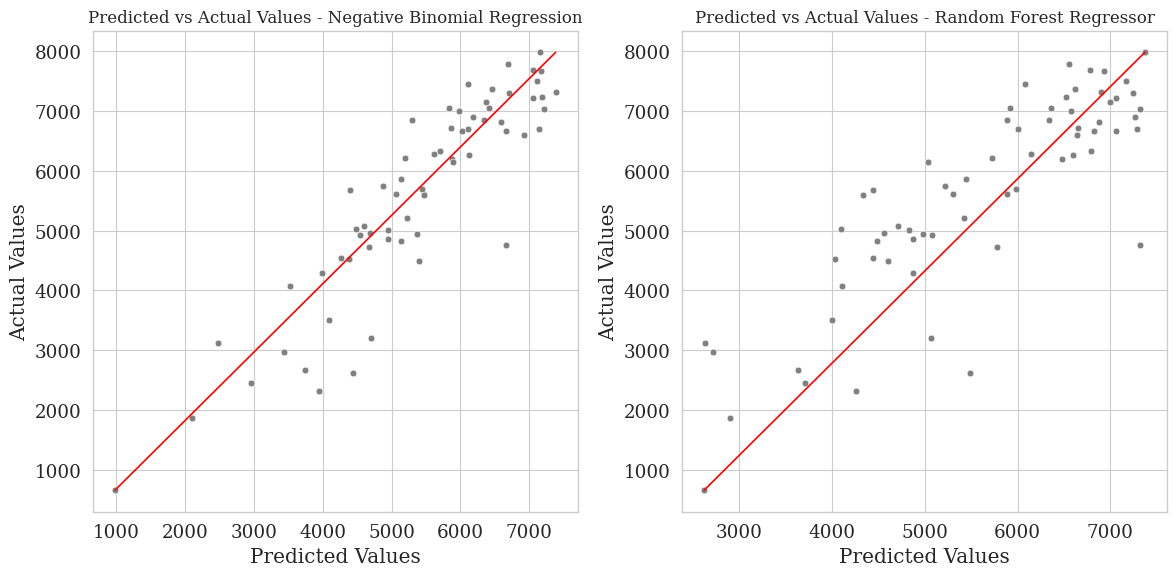

In [51]:
# Initialize pyplot figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create Actuals vs. Predictions Scatterplot for predictions made by Random Forest
sns.scatterplot(x=y_pred_RF, y=y_test, ax=axs[1], color='gray')
# Optical adjustments (X/Y-Lables, Title, Line of perfect prediction)
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_title('Predicted vs Actual Values - Random Forest Regressor', fontsize=12)
axs[1].plot([min(y_pred_RF), max(y_pred_RF)], [min(y_test), max(y_test)], color='red')  # line of perfect prediction
axs[1].grid(True)

# Create Actuals vs. Predictions Scatterplot for predictions made by GLM
sns.scatterplot(x=y_pred_negbin, y=y_test, ax=axs[0], color='gray')
# Optical adjustments (X/Y-Lables, Title, Line of perfect prediction)
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Actual Values')
axs[0].set_title('Predicted vs Actual Values - Negative Binomial Regression', fontsize=12)
axs[0].plot([min(y_pred_negbin), max(y_pred_negbin)], [min(y_test), max(y_test)], color='red')  # line of perfect prediction
axs[0].grid(True)

# Adjust the layout
plt.tight_layout()

# Show plot
plt.show()

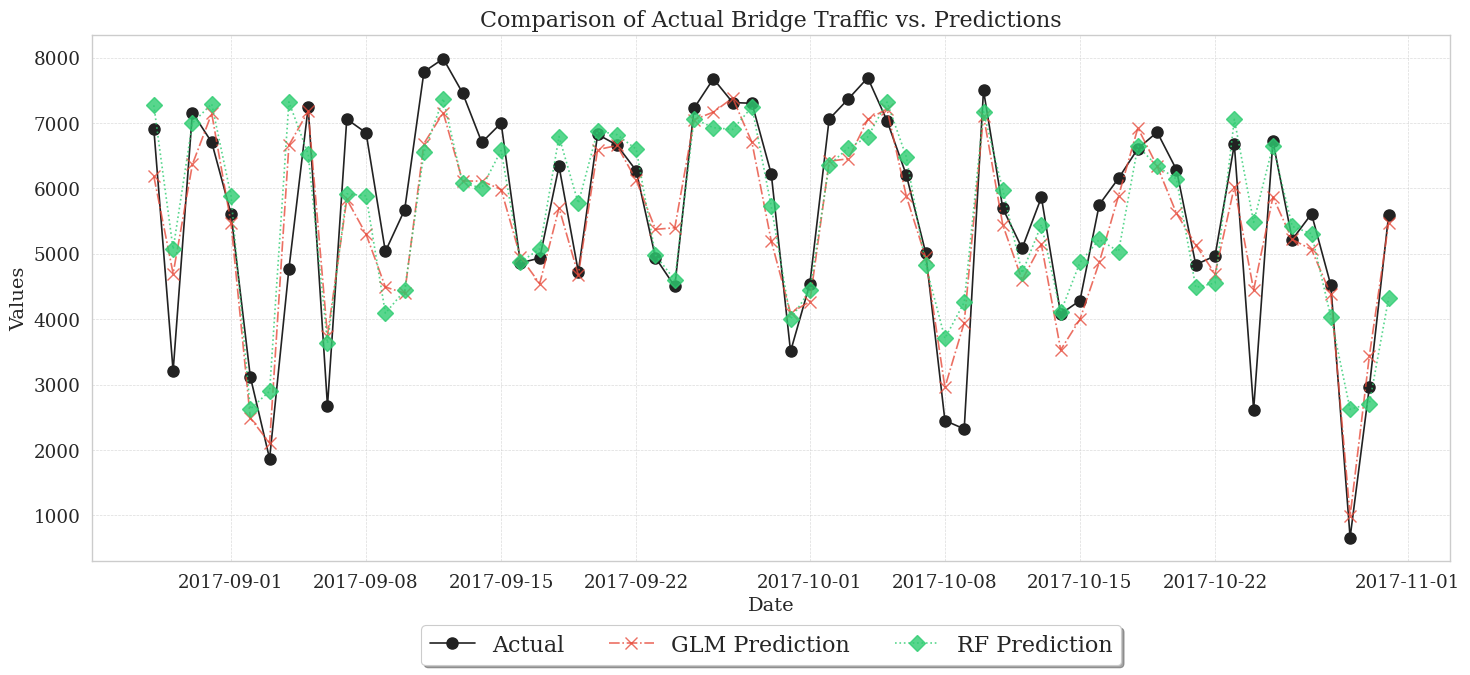

In [52]:
# Add predictions made by both models to the test set
test_set["Predicted_RF"] = y_pred_RF
test_set["Predicted_GLM"] = y_pred_negbin

# Intialize pylot figure
plt.figure(figsize=(15, 7))

# Plot actual values with larger markers
plt.plot(test_set['Date'], test_set['Manhattan Bridge'], label='Actual', color='#222222', marker='o', markersize=8)

# Plot GLM predictions with a distinct line style and marker
plt.plot(test_set['Date'], test_set['Predicted_GLM'], label='GLM Prediction', color='#e74c3c', linestyle='-.', marker='x', markersize=8, alpha = 0.8)

# Plot Random Forest predictions with a different line style and marker
plt.plot(test_set['Date'], test_set['Predicted_RF'], label='RF Prediction', color='#2ecc71', linestyle=':', marker='D', markersize=8, alpha = 0.8)

# Adjust Lables and Title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Actual Bridge Traffic vs. Predictions', fontsize=16)

# Format the date axis to prevent overlapping and improve readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Make gridlines lighter
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Place the legend outside the plot to avoid covering data points
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=3, prop={'size': 16})

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

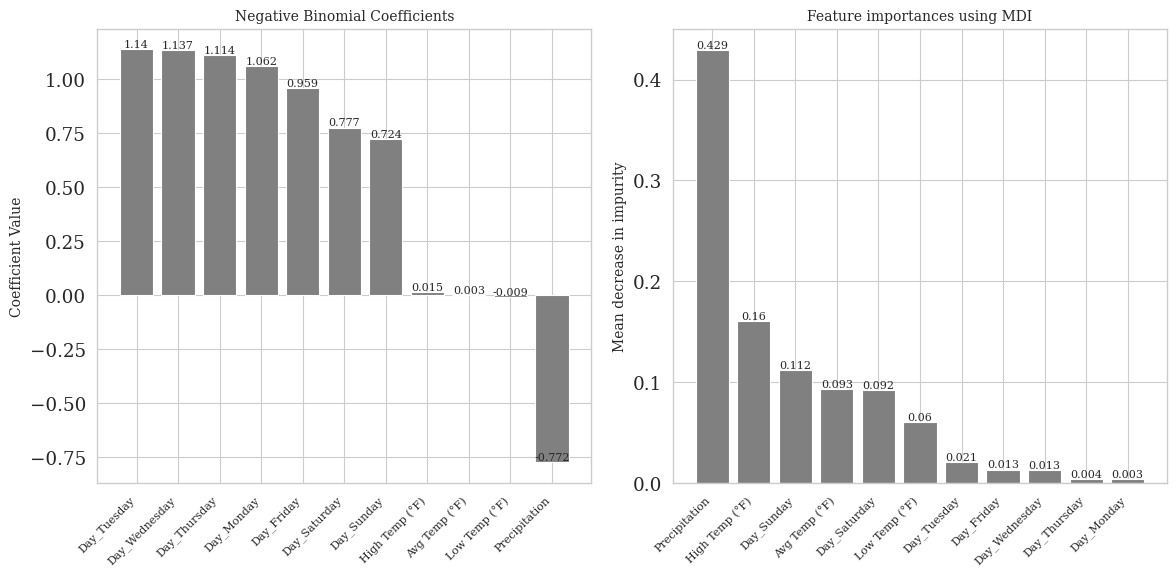

In [54]:
# Get feature importances from Random Forest
importances = rf_best.feature_importances_

# Add importances and corresponding column names to a dataframe
forest_importances = pd.Series(importances, X_train.columns).sort_values(ascending=False)

# Get coefficients from Negative Binomial model
nb_coefficients = glm_negbin_results.params[1:]  # Exclude intercept
nb_coefficients = pd.Series(nb_coefficients, index=glm_negbin_results.model.exog_names[1:]).sort_values(ascending=False)

# Initialize pyplot figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Random Forest feature importances
bars_rf = axs[1].bar(forest_importances.index, forest_importances, color = "gray")
axs[1].set_title("Feature importances using MDI", fontsize=10)
axs[1].set_ylabel("Mean decrease in impurity", fontsize=10)
axs[1].set_xticklabels(forest_importances.index, rotation = 45, ha="right", fontsize=8)


# Add the actual numbers on top of each bar, centered (Random Forest)
for bar in bars_rf:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

# Plot Negative Binomial coefficients
bars_nb = axs[0].bar(nb_coefficients.index, nb_coefficients, color = "gray")
axs[0].set_title("Negative Binomial Coefficients", fontsize=10)
axs[0].set_ylabel("Coefficient Value", fontsize=10)
axs[0].set_xticklabels(nb_coefficients.index, rotation = 45, ha="right", fontsize=8)

# Add the actual numbers on top of each bar, centered (Negative Binomial)
for bar in bars_nb:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()